In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report

In [220]:
df = pd.read_csv('projects.csv')
df_original = df
df.head()

,name,category,main_category,currency,deadline,goal,launched,state
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed


In [221]:
df.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'state'],
      dtype='object')

In [222]:
X = df.drop(columns=['state', 'name'])
y = df.state


In [223]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.1/0.9, stratify=y_train_val)
X_train.shape, X_val.shape, X_test.shape

((269269, 6), (33659, 6), (75733, 6))

In [224]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269269 entries, 309501 to 105783
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category       269269 non-null  object 
 1   main_category  269269 non-null  object 
 2   currency       269269 non-null  object 
 3   deadline       269269 non-null  object 
 4   goal           269269 non-null  float64
 5   launched       269269 non-null  object 
dtypes: float64(1), object(5)
memory usage: 14.4+ MB


#  Preprocessing

In [225]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [226]:
def ohe_train_encode(X):
  ohe = OneHotEncoder(sparse_output=False)
  X_ohe = ohe.fit_transform(X)
  std = StandardScaler()
  X_ohe_scl = std.fit_transform(X_ohe)
  return X_ohe_scl, ohe, std

In [227]:
def ohe_not_train_encode(X, ohe=None, std=None):
  X_ohe = ohe.transform(X)
  X_ohe_scl = std.transform(X_ohe)
  return X_ohe_scl

In [228]:
def cyclical_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    df.drop(col, axis=1, inplace=True)
    return df

In [229]:
def train_label_encoder(y):
  lbl_enc = LabelEncoder()
  encoded_labels = lbl_enc.fit_transform(y)
  return encoded_labels, lbl_enc

In [230]:
def not_train_label_encoder(y, lbl_enc=None):
  encoded_labels = lbl_enc.transform(y)
  return encoded_labels

In [231]:
y_train, lbl_enc = train_label_encoder(y_train)
y_val = not_train_label_encoder(y_val, lbl_enc=lbl_enc)
y_test = not_train_label_encoder(y_test, lbl_enc=lbl_enc)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(269269,)
(33659,)
(75733,)


In [232]:
X_train_to_ohe = X_train[['category','main_category', 'currency' ]]
X_train_to_ohe.head()

X_val_to_ohe = X_val[['category','main_category', 'currency' ]]
X_val_to_ohe.head()

X_test_to_ohe = X_test[['category','main_category', 'currency' ]]
X_test_to_ohe.head()

,category,main_category,currency
366272,Small Batch,Food,USD
28376,DIY,Crafts,USD
320821,Tabletop Games,Games,USD
372897,Webseries,Film & Video,AUD
114257,Translations,Publishing,USD


In [233]:
X_train['deadline'] = pd.to_datetime(X_train['deadline'])
X_train['year_deadline'] = X_train['deadline'].dt.year
X_train['month_deadline'] = X_train['deadline'].dt.month
X_train['day_deadline'] = X_train['deadline'].dt.day
X_train.drop('deadline', axis=1, inplace=True)

X_train['launched'] = pd.to_datetime(X_train['launched'])
X_train['year_launched'] = X_train['launched'].dt.year
X_train['month_launched'] = X_train['launched'].dt.month
X_train['day_launched'] = X_train['launched'].dt.day
X_train['hour_launched'] = X_train['launched'].dt.hour
X_train.drop('launched', axis=1, inplace=True)

print(X_train)

              category main_category currency     goal  year_deadline  \
309501         Gadgets    Technology      EUR   6000.0           2014   
207725            Food          Food      CAD  15000.0           2014   
64371        Webseries  Film & Video      USD  15000.0           2014   
99660   Tabletop Games         Games      USD   5800.0           2015   
141253     Video Games         Games      USD  50000.0           2013   
...                ...           ...      ...      ...            ...   
225650           Music         Music      USD   5000.0           2012   
175987             Art           Art      USD   4500.0           2017   
62536         Painting           Art      USD  25000.0           2017   
328817         Theater       Theater      USD   2000.0           2010   
105783     Accessories       Fashion      USD    500.0           2015   

        month_deadline  day_deadline  year_launched  month_launched  \
309501              12            19           2014 

In [234]:
X_val['deadline'] = pd.to_datetime(X_val['deadline'])
X_val['year_deadline'] = X_val['deadline'].dt.year
X_val['month_deadline'] = X_val['deadline'].dt.month
X_val['day_deadline'] = X_val['deadline'].dt.day
X_val.drop('deadline', axis=1, inplace=True)

X_val['launched'] = pd.to_datetime(X_val['launched'])
X_val['year_launched'] = X_val['launched'].dt.year
X_val['month_launched'] = X_val['launched'].dt.month
X_val['day_launched'] = X_val['launched'].dt.day
X_val['hour_launched'] = X_val['launched'].dt.hour
X_val.drop('launched', axis=1, inplace=True)

print(X_val)

            category main_category currency      goal  year_deadline  \
226710          Food          Food      USD  250000.0           2015   
355318      Software    Technology      AUD   50000.0           2014   
226341         Music         Music      USD   30000.0           2015   
324310  Film & Video  Film & Video      USD     220.0           2010   
278134          Apps    Technology      GBP    6500.0           2017   
...              ...           ...      ...       ...            ...   
130918   Photography   Photography      USD    1500.0           2011   
280306          Apps    Technology      USD   25000.0           2017   
72541         Comics        Comics      USD    3000.0           2015   
34157      Art Books    Publishing      USD      50.0           2016   
153446      Hardware    Technology      USD   50000.0           2013   

        month_deadline  day_deadline  year_launched  month_launched  \
226710              11            19           2015             

In [235]:
X_test['deadline'] = pd.to_datetime(X_test['deadline'])
X_test['year_deadline'] = X_test['deadline'].dt.year
X_test['month_deadline'] = X_test['deadline'].dt.month
X_test['day_deadline'] = X_test['deadline'].dt.day
X_test.drop('deadline', axis=1, inplace=True)

X_test['launched'] = pd.to_datetime(X_test['launched'])
X_test['year_launched'] = X_test['launched'].dt.year
X_test['month_launched'] = X_test['launched'].dt.month
X_test['day_launched'] = X_test['launched'].dt.day
X_test['hour_launched'] = X_test['launched'].dt.hour
X_test.drop('launched', axis=1, inplace=True)

print(X_test)

              category main_category currency        goal  year_deadline  \
366272     Small Batch          Food      USD      7000.0           2014   
28376              DIY        Crafts      USD      3000.0           2015   
320821  Tabletop Games         Games      USD      5000.0           2015   
372897       Webseries  Film & Video      AUD     16000.0           2018   
114257    Translations    Publishing      USD  25000000.0           2014   
...                ...           ...      ...         ...            ...   
231809       Thrillers  Film & Video      USD      6000.0           2016   
54209       Nonfiction    Publishing      USD      5400.0           2012   
144948           Music         Music      USD      1200.0           2011   
334595         Fashion       Fashion      AUD      5000.0           2016   
71292       Nonfiction    Publishing      USD      1000.0           2014   

        month_deadline  day_deadline  year_launched  month_launched  \
366272          

In [236]:
X_train_to_cyclical = X_train[['month_deadline', 'day_deadline', 'month_launched', 'day_launched', 'hour_launched']]
X_train_to_cyclical.head()

X_val_to_cyclical = X_val[['month_deadline', 'day_deadline', 'month_launched', 'day_launched', 'hour_launched']]
X_val_to_cyclical.head()

X_test_to_cyclical = X_test[['month_deadline', 'day_deadline', 'month_launched', 'day_launched', 'hour_launched']]
X_test_to_cyclical.head()

,month_deadline,day_deadline,month_launched,day_launched,hour_launched
366272,11,17,10,17,3
28376,4,21,4,3,22
320821,8,4,6,25,7
372897,1,2,12,3,7
114257,12,1,10,3,23


In [237]:
X_train_ohe, ohe, std = ohe_train_encode(X_train_to_ohe)
X_val_ohe = ohe_not_train_encode(X_val_to_ohe, ohe=ohe, std=std)
X_test_ohe = ohe_not_train_encode(X_test_to_ohe, ohe=ohe, std=std)

In [238]:
X_train_month_deadline_encoded = cyclical_encode(X_train_to_cyclical[['month_deadline']], 'month_deadline', 12)
X_val_month_deadline_encoded = cyclical_encode(X_val_to_cyclical[['month_deadline']], 'month_deadline', 12)
X_test_month_deadline_encoded = cyclical_encode(X_test_to_cyclical[['month_deadline']], 'month_deadline', 12)

X_train_month_launched_encoded = cyclical_encode(X_train_to_cyclical[['month_launched']], 'month_launched', 12)
X_val_month_launched_encoded = cyclical_encode(X_val_to_cyclical[['month_launched']], 'month_launched', 12)
X_test_month_launched_encoded = cyclical_encode(X_test_to_cyclical[['month_launched']], 'month_launched', 12)

X_train_day_deadline_encoded = cyclical_encode(X_train_to_cyclical[['day_deadline']], 'day_deadline', 30)
X_val_day_deadline_encoded = cyclical_encode(X_val_to_cyclical[['day_deadline']], 'day_deadline', 30)
X_test_day_deadline_encoded = cyclical_encode(X_test_to_cyclical[['day_deadline']], 'day_deadline', 30)

X_train_day_launched_encoded = cyclical_encode(X_train_to_cyclical[['day_launched']], 'day_launched', 30)
X_val_day_launched_encoded = cyclical_encode(X_val_to_cyclical[['day_launched']], 'day_launched', 30)
X_test_day_launched_encoded = cyclical_encode(X_test_to_cyclical[['day_launched']], 'day_launched', 30)

X_train_hour_launched_encoded = cyclical_encode(X_train_to_cyclical[['hour_launched']], 'hour_launched', 30)
X_val_hour_launched_encoded = cyclical_encode(X_val_to_cyclical[['hour_launched']], 'hour_launched', 30)
X_test_hour_launched_encoded = cyclical_encode(X_test_to_cyclical[['hour_launched']], 'hour_launched', 30)

<ipython-input-228-1e7fc143c117>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
<ipython-input-228-1e7fc143c117>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
<ipython-input-228-1e7fc143c117>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [239]:
print(X_train_ohe.shape)
print(X_test_ohe.shape)
print(X_val_ohe.shape)

print(X_test_month_deadline_encoded.shape)
print(X_test_month_launched_encoded.shape)
print(X_test_day_deadline_encoded.shape)
print(X_test_day_launched_encoded.shape)
print(X_test_hour_launched_encoded.shape)

print(type(X_val_ohe))

(269269, 188)
(75733, 188)
(33659, 188)
(75733, 2)
(75733, 2)
(75733, 2)
(75733, 2)
(75733, 2)
<class 'numpy.ndarray'>


In [240]:
X_train = d = np.concatenate((X_train_ohe, X_train_month_deadline_encoded,
                              X_train_month_launched_encoded,
                              X_train_day_deadline_encoded,
                              X_train_day_launched_encoded,
                              X_train_hour_launched_encoded
                              ), axis=1)

X_val = d = np.concatenate((X_val_ohe, X_val_month_deadline_encoded,
                              X_val_month_launched_encoded,
                              X_val_day_deadline_encoded,
                              X_val_day_launched_encoded,
                              X_val_hour_launched_encoded
                              ), axis=1)

X_test = d = np.concatenate((X_test_ohe, X_test_month_deadline_encoded,
                              X_test_month_launched_encoded,
                              X_test_day_deadline_encoded,
                              X_test_day_launched_encoded,
                              X_test_hour_launched_encoded
                              ), axis=1)


# Model

In [ ]:
!pip install keras_tuner

In [243]:
from keras_tuner.tuners import RandomSearch

In [244]:
# hyperp tuning
def build_model(hp):
    model = keras.Sequential([
        keras.Input(shape=(X_train.shape[1],), name="input"),
        layers.BatchNormalization(),
        layers.Dense(hp.Int('units1', 16, 64, step=16), activation=keras.activations.selu, name="hidden_layer1", kernel_initializer=keras.initializers.LecunNormal),
        keras.layers.Dropout(rate=hp.Float('dropout2', 0, 0.5, step=0.1)),
        layers.BatchNormalization(),
        layers.Dense(hp.Int('units2', 8, 32, step=8), activation=keras.activations.selu, name="hidden_layer2", kernel_initializer=keras.initializers.LecunNormal),
        layers.Dense(1, activation="sigmoid", name="output")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='my_model'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Trial 1 Complete [00h 20m 13s]
val_accuracy: 0.6726779341697693

Best val_accuracy So Far: 0.6726779341697693
Total elapsed time: 00h 20m 13s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
32                |16                |units1
0                 |0                 |dropout2
8                 |8                 |units2
0.00041315        |0.0094583         |learning_rate

Epoch 1/20
8415/8415 [==============================] - 23s 3ms/step - loss: 0.6089 - accuracy: 0.6703 - val_loss: 0.6462 - val_accuracy: 0.6638
Epoch 2/20
8415/8415 [==============================] - 19s 2ms/step - loss: 0.6038 - accuracy: 0.6748 - val_loss: 0.6425 - val_accuracy: 0.6640
Epoch 3/20
8415/8415 [==============================] - 20s 2ms/step - loss: 0.6024 - accuracy: 0.6757 - val_loss: 0.6414 - val_accuracy: 0.6646
Epoch 4/20
4885/8415 [================>.............] - ETA: 8s - loss: 0.6021 - accuracy: 0.6749

KeyboardInterrupt: ignored

In [245]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [246]:
print(best_hyperparameters.get('units1'))
print(best_hyperparameters.get('units2'))
print(best_hyperparameters.get('learning_rate'))
print(best_hyperparameters.get('dropout2'))

16
8
0.009458325122356186
0.0


# Initialization

In [247]:
model = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1],), name="input"),
        layers.BatchNormalization(),
        layers.Dense(8, activation=keras.activations.selu, name="hidden_layer2", kernel_initializer=keras.initializers.LecunNormal, kernel_regularizer='l1_l2'),
        layers.Dense(1, activation="sigmoid", name="output")
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 198)              792       
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 8)                 1592      
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 2,393
Trainable params: 1,997
Non-trainable params: 396
_________________________________________________________________


In [248]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.ExponentialDecay(0.1, decay_steps=100, decay_rate=0.96, staircase=True)),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

In [249]:
cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)


# Training

In [250]:
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

Epoch 1/50
8415/8415 [==============================] - 20s 2ms/step - loss: 0.7365 - accuracy: 0.6559 - val_loss: 0.6401 - val_accuracy: 0.6681
Epoch 2/50
8415/8415 [==============================] - 16s 2ms/step - loss: 0.6229 - accuracy: 0.6695 - val_loss: 0.6205 - val_accuracy: 0.6709
Epoch 3/50
8415/8415 [==============================] - 16s 2ms/step - loss: 0.6168 - accuracy: 0.6712 - val_loss: 0.6185 - val_accuracy: 0.6711
Epoch 4/50
8415/8415 [==============================] - 17s 2ms/step - loss: 0.6163 - accuracy: 0.6715 - val_loss: 0.6185 - val_accuracy: 0.6711
Epoch 5/50
8415/8415 [==============================] - 17s 2ms/step - loss: 0.6165 - accuracy: 0.6712 - val_loss: 0.6185 - val_accuracy: 0.6711
Epoch 6/50
8415/8415 [==============================] - 18s 2ms/step - loss: 0.6165 - accuracy: 0.6710 - val_loss: 0.6184 - val_accuracy: 0.6712
Epoch 7/50
8415/8415 [==============================] - 17s 2ms/step - loss: 0.6164 - accuracy: 0.6705 - val_loss: 0.6187 - val_ac

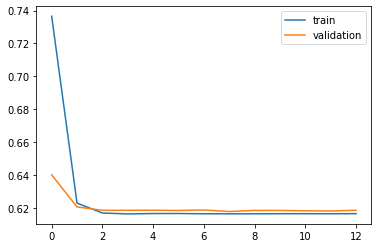

In [251]:
reset_seeds()

fitted_model = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=cb, # use early stopping
)

pd.Series(fitted_model.history['loss']).plot(label='train')
pd.Series(fitted_model.history['val_loss']).plot(label='validation')
plt.legend()

# Evaluation

In [252]:
y_pred = (model.predict(X_test) > 0.5) * 1
print(classification_report(y_test, y_pred))

2367/2367 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.70      0.87      0.78     48942
           1       0.57      0.31      0.40     26791

    accuracy                           0.67     75733
   macro avg       0.64      0.59      0.59     75733
weighted avg       0.65      0.67      0.64     75733



In [253]:
# General metrics 
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision: ', round(precision_score(y_test, y_pred.astype(int), average='weighted'), 3))
print('Recall: ', round(recall_score(y_test, y_pred.astype(int), average='weighted'), 3))
print('F1 score: ', round(f1_score(y_test, y_pred.astype(int), average='weighted'), 3))

Precision:  0.654
Recall:  0.674
F1 score:  0.644


In [254]:
# Save model
tf.saved_model.save(model, 'saved_model')